[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/advection_diffusion_2d/advection-diffusion-2d.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/examples/blob/main/examples/PyMPDATA_examples/advection_diffusion_2d/advection-diffusion-2d.ipynb)

In [1]:
from open_atmos_jupyter_utils import show_plot

TOC:
- run a basic constant-coefficient advection-diffusion simulation with Trixi.jl
- run analogous simulation with PyMPDATA
- compare output

## common settings

In [2]:
SETUP = {
    "nx": 32,
    "ny": 16,
    "Cx": 0.5,
    "Cy": 0.25,
    "dt": 1.0
}

import json
with open('setup.json', 'w', encoding='UTF-8') as f:
    json.dump(SETUP, f)

## Trixi.jl

In [3]:
%%writefile trixi.jl
import Pkg
Pkg.add(["JSON", "Trixi", "OrdinaryDiffEq"])
using JSON, Trixi, OrdinaryDiffEq

setup = JSON.parsefile("setup.json")

solver = DGSEM(polydeg=0)
equations = LinearScalarAdvectionEquation2D(setup["Cx"], setup["Cy"])

function initial_condition(x, t, equations::LinearScalarAdvectionEquation2D)
    return SVector(exp(-100 * (x[1]^2 + x[2]^2)))
end

cells_per_dimension = (setup["nx"], setup["ny"]) 
coordinates_min = (-1.0, -1.0)
coordinates_max = ( 1.0,  1.0)

mesh = StructuredMesh(cells_per_dimension, coordinates_min, coordinates_max; periodicity=true)
semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, solver) 

tspan = (0.0, 0.1)
ode = semidiscretize(semi, tspan)

summary_callback = SummaryCallback()
save_solution = SaveSolutionCallback(dt = setup["dt"],
                                     save_initial_solution = true,
                                     save_final_solution = true)

callbacks = CallbackSet(summary_callback, save_solution)

time_int_tol = 1e-6
sol = solve(ode, SSPRK33(); abstol = time_int_tol, reltol = time_int_tol,
            dt = setup["dt"], ode_default_options()..., callback = callbacks)

summary_callback()

Overwriting trixi.jl


In [4]:
%%bash
julia trixi.jl 2>&1

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`

████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 2                                                                │
│ mesh: ………………………………………………………………… StructuredMesh{2, Float64}                                       │
│ equations: …………………………………………………… LinearScalarAdvectionEquation2D                                  │
│ initial condition: ……………………………… initial_condit

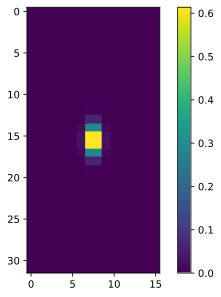

HTML(value="<a href='./tmp0cyjs91q.pdf' target='_blank'>./tmp0cyjs91q.pdf</a><br>")

In [5]:
import h5py
import matplotlib.pyplot as plt

with h5py.File('out/solution_000000.h5', 'r') as f:
    plt.imshow(f['variables_1'][:].reshape(SETUP['ny'], SETUP['nx']).transpose())
    plt.colorbar()
    show_plot()

## PyMPDATA

In [6]:
import os
import numpy as np
import sympy as sp
from IPython.display import display
from ipywidgets import FloatProgress
from matplotlib.animation import FuncAnimation
from PyMPDATA import Solver, ScalarField, VectorField, Stepper, Options
from PyMPDATA.boundary_conditions import Periodic

In [7]:
steps_per_iter = 1
opt = Options(n_iters=3, non_zero_mu_coeff=True, infinite_gauge=True, nonoscillatory=True)

In [8]:
x0 = -1.
y0 = -1.
boundary_conditions = (Periodic(), Periodic())

In [9]:
mu = 0.05
c = 1.
min_x, min_y = -1, -1
max_x, max_y = 1, 1
dx = (max_x - min_x) / SETUP['nx']
dy = (max_y - min_y) / SETUP['ny']
solution_symbolic = sp.sympify("sin(pi*(x+y))*exp(-mu*pi**2*t) + 1", rational=True)
solution = solution_symbolic.subs({"mu": mu})

In [10]:
def init_conditions(x, y):
    return solution_symbolic.subs({"t":0, "x": x, "y": y}).evalf()

In [11]:
z = np.array(
    [
        # [
            init_conditions(x, y) for x in np.linspace(min_x, max_x, SETUP['nx'])
        # ]
        for y in np.linspace(min_y, max_y, SETUP['ny'])
    ],
    dtype=float
).reshape((SETUP['nx'], SETUP['ny']))

In [12]:
advectee = ScalarField(data=z, halo=opt.n_halo, boundary_conditions=boundary_conditions)

In [13]:
field_x = np.full((SETUP['nx']+1, SETUP['ny']), SETUP['Cx'], dtype=opt.dtype)
field_y = np.full((SETUP['nx'], SETUP['ny']+1), SETUP['Cy'], dtype=opt.dtype)
advector = VectorField(
    data=(field_x, field_y),
    halo=opt.n_halo,
    boundary_conditions=(boundary_conditions[0], Periodic())
)

In [14]:
stepper = Stepper(options=opt, n_dims=2)

In [15]:
# create a solver
solver = Solver(stepper=stepper, advector=advector, advectee=advectee)

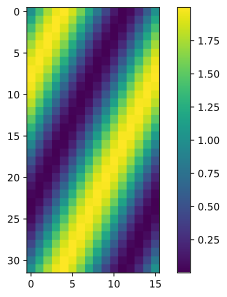

HTML(value="<a href='./tmp6tlndyub.pdf' target='_blank'>./tmp6tlndyub.pdf</a><br>")

In [16]:
plt.imshow(solver.advectee.get().copy(), cmap='viridis')
plt.colorbar()
show_plot()

In [17]:
progbar = FloatProgress(value=0, min=0, max=1)
display(progbar)

states_history = [solver.advectee.get().copy()]
n_range = 100
for i in range(n_range):
    solver.advance(n_steps=10, mu_coeff=(mu, mu))
    states_history.append(solver.advectee.get().copy())
    progbar.value = (i + 1.) / n_range

FloatProgress(value=0.0, max=1.0)

In [18]:
# save each frame as a png to animation2 folder
os.makedirs("animation2", exist_ok=True)
for i, state in enumerate(states_history):
    # flip the image vertically
    state = np.flipud(state)
    plt.imshow(state, cmap='viridis')
    plt.colorbar()
    plt.savefig(f"animation2/frame_{i:03d}.png")
    plt.close()

In [19]:
def get_advection_diffusion_gif(states):
    fig, ax = plt.subplots()
    ax.set_xlim(0, SETUP['nx'])
    ax.set_ylim(0, SETUP['ny'])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Advection-Diffusion Equation")
    im = ax.imshow(states[0], cmap='viridis')
    def update(i):
        im.set_array(states[i])
        return im
    anim = FuncAnimation(fig, update, frames=len(states), blit=True)
    
    anim.save("advection_diffusion.gif", writer='imagemagick', fps=10)

In [ ]:
get_advection_diffusion_gif(states_history)